# Machine Learning. Caso: Self-tuning robots

Instrucciones:
* Por favor, complete las tareas de este notebook. Deberá enviar este notebook, así como una versión en PDF, a la plataforma Univirtual.
* Para crear el PDF, vaya a Archivo > Descargar como. Puede exportar a PDF mediante Latex, o exportar a HTML y luego imprimir a PDF.
* Añada una explicación clara de su enfoque y una interpretación detallada de sus resultados para cada subpregunta. Para ello, utilice celdas Markdown.

* Añada a continuación los nombres de todos los miembros del equipo.

**Integrantes:**

1.   Integrante 1:
2.   Integrante 2:

In [ ]:
!pip install preamble

In [ ]:
!pip install openml

In [ ]:
# imports generales
%matplotlib inline
from preamble import *
import matplotlib.pyplot as plt
import openml as oml
plt.rcParams['savefig.dpi'] = 100 # Esto controla el tamaño de tus imágenes

## Parte 1. Navegación del robot
El dataset [Wall robot navigation](https://www.openml.org/d/1497) contiene datos de entrenamiento para un robot equipado con sensores de ultrasonidos.  Basándose en las lecturas de 24 sensores, el robot tiene que averiguar cómo moverse por un espacio de oficinas sin chocar con las paredes u otros obstáculos. En esta tarea, el robot utiliza una SVM para aprender a hacerlo.

Sin embargo, en lugar de construir un modelo estático, queremos que el robot ajuste regularmente los hiperparámetros de su modelo **SVM**.  De esta forma será más resistente a cambios, por ejemplo, a la rotura de un sensor. Dado que el robot está muy ocupado, este reentrenamiento regular debe llevar el menor tiempo posible. Tu tarea es implemtar un algoritmo de ajuste rápido (fast tuning algorithm) que optimice las configuraciones de hiperparámetros más rápido y mejor que algoritmos de random search o grid search.

## Los datos
Los datos se visualizan a continuación. Contienen trazas de ejecuciones de entrenamiento del robot. En la siguiente figura, se muestran las dos primeras lecturas de los sensores, codificadas por colores según la acción correcta que se debe realizar (avanzar, ir a la izquierda o a la derecha: move forward, left or right). Puedes tomar estos puntos de datos como muestras independientes, es decir,  nunca necesitas mi rar al punto de datos anterior ('previous' data point).

In [ ]:
# Descarga los datos de navegación del Wall Robot Navigation desde OpenML.
robot = oml.datasets.get_dataset(1497)
X, y, _, _ = robot.get_data(target=robot.default_target_attribute, dataset_format = 'array');
X_d, y_d, _, _ = robot.get_data(target=robot.default_target_attribute);

labels = ['Move-Forward','Slight-Right-Turn','Sharp-Right-Turn','Slight-Left-Turn']

In [ ]:
X

In [ ]:
y

In [ ]:
X_d

In [ ]:
y_d

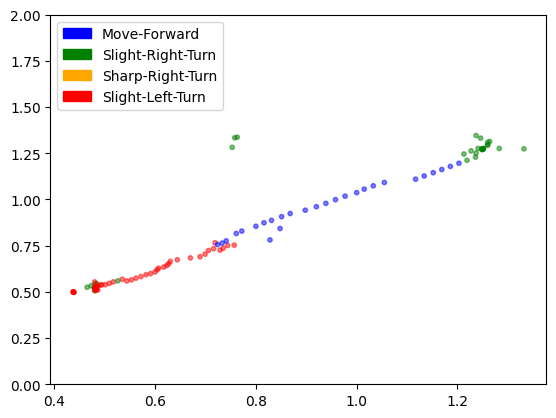

In [ ]:
import matplotlib.patches as mpatches
from matplotlib import colors

cmap = colors.ListedColormap(['blue', 'green', 'orange', 'red'])
legend_handles = list()
for i in range(4):
    legend_handles.append(mpatches.Patch(color=cmap(i), label=labels[i]))
plt.legend(handles=legend_handles, loc='upper left')

n = 120 # primeros 120 puntos
plt.scatter(X[:,0][0:n], X[:,1][0:n], c=y[0:n], cmap=cmap, alpha=0.5, s=10)
plt.ylim(0,2);

## Optimización multifidelidad (Multi-fidelity optimization)
Implementaremos una técnica de optimización rápida conocida generalmente como optimización multifidelidad (_multi-fidelity optimization_). En lugar de entrenar el modelo en todos los datos de entrenamiento para cada configuración de hiperparámetros, utilizaremos el siguiente procedimiento:

Reducción sucesiva a la mitad (Successive Halving, puedes guiarte por la imagen de líneas siguientes):
- Recolectar $n$ configuraciones aletaorias de hiperparámetros hyperparameter configurations (cuadrados en la imagen inferior)
- Partir en la mitad la data de entrenamiento original, y repetir esta acción $k$ veces
- valuar todas las configuraciones de hiperparámetros en la muestra más pequeña
- seleccione el 50% de las mejores configuraciones (cuadrados verdes) y ejecútelas en la siguiente muestra más grande
- repetir hasta que se hayan utilizado todos los datos de entrenamiento, y devolver la mejor de las configuraciones restantes (cuadrados blancos)





<img src="./images/hyperbandFoto.png" width="800"/>

In [ ]:
# Hcodigo de ayuda
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values

    values: flattened array with all evaluation results, varying the first hyperparameter first
    xlabel: name of the first hyperparameter
    ylabel: name of the second hyperparameter
    xticklabels: values of the first hyperparameter
    yticklabels: values of the second hyperparameter
    cmap: colormap
    vmin: minimal score
    vmax: maximal score
    ax: plot axes
    fmt: format for printing the scores
    printvalues: whether to print the scores
    """
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if(printvalues):
        for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.mean(color[:3]) > 0.5:
                c = 'k'
            else:
                c = 'w'
            ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

## Preguntas

1_ Landscape analysis: Visualizar la configuración del espacio de búsqueda (2 puntos)

- Haga búsqueda grid ( grid search) para un SVM con el kernel RBF . Varíe los parámetros C and $\gamma$ al mismo tiempo, en una escala logarítmica de $2^{-15}$ to $2^{15}$. Utilice al menos 20 valores para cada uno, a menos que esté limitado por los recursos computacionales.
    - Sugerencia: Empieza con una cuadrícula pequeña y comprueba cuánto tardas. Si es rápido, puede utilizar una rejilla más fina.
    - Puedes utilizar la validación: 3-fold cross-validation
- Visualice los resultados en un gráfico (plot) $C \times \gamma \rightarrow \rho$ siendo $\rho$ la performance del modelo (Accuracy) visualizado como el color de los puntos de datos.
    - Puede utilizar el código anterior para ello..
- Interpreta y explica el resultado. ¿Hay un valor óptimo único? ¿Es el landscape soft (suave)? ¿Tiene sentido esto en función a lo conoces acerca de los SVMs y el rol de los parámetros $C$ and $\gamma$?

2_ Implemente la reducción sucesiva a la mitad (Successive Halving) (3 puntos)
* Implementa una función que realice un sólo paso (single step) de los pasos descritos arriba:
    - Input: data de ejemplo, lista de configuraciones de entrada
    - Output: lista de configuraciones seleccionadas
    - Imprimir una traza de la mejor configuración y su precisión (accuracy) después de cada paso
* Implementar el bucle externo
    - Input: El conjunto de datos completo (dataset entero) y la lista de configuraciones aleatorias (random)
    - Output:  la mejor configuración final y el mejor modelo
*Ejecute todo el procedimiento utilizando $n=100$ y $k=5$
* Analice los resultados. ¿Es esto más rápido/mejor que una búsqueda grid (grid search)  0r busqueda aleatoria (random search)? ¿Sigue mejorando en las últimas ejecuciones?

3_ Visualice la reducción sucesiva a la mitad (Successive Halving) (2.5 puntos)
* Para cada paso, genere un gráfico (plot) con lo siguiente:
    - El heatmap como se produce en el punto 1. Esto requiere una búsqueda grid completa (grid search) en la submuestra de los datos de cada paso.
    - Las configuraciones aleatorias seleccionadas superpuestas (por ejemplo, utilice una grafica de puntos/cruces).
* La respuesta debe ser una serie de 5 de estos gráficos (plots)
* Interprete y explique el resultado. ¿Parece que el método hace algo útil?

4_  Cambio de enfoque, usar otra técnica (Random Forests): (2 puntos)


*   Implementa una función `evaluate_RF` que mida el rendimiento de un clasificador Random Forest, utilizando árboles de (max) profundidad 2,8,32,64, para cualquier número de árboles en el conjunto (ensemble) (`n_estimators`).
Para la evaluación debe medir la precisión usando 3-fold cross-validation.
Use `random_state=1` para garantizar la reproducibilidad. Por último, muestra (plot)  los resultados para al menos 5 valores de `n_estimators` que oscilen entre 1 y 30.  Por supuesto, puede reutilizar el código de laboratorios y tareas anteriores. Interprete los resultados.
Puede tomar una submuestra de 50% subsample para acelerar el plot de los gráficos.

*  ¿Indique sus conclusiones?. ¿Cuál sería la comparación de rendimiento usando random forest con respecto a la pregunta 1? ¿Utilizarías alguna idea del punto 1 para mejorar tus resultados?.







## 2 Técnicas basadas en regiones para la segmentación de imágenes (2.5 puntos)

La segmentación de imágenes es el proceso de **asignar una etiqueta a cada píxel de una imagen** de forma que los píxeles con la misma etiqueta compartan determinadas características. Como consecuencia, produce regiones cuyos píxeles tienen propiedades similares, por ejemplo, intensidad, color, textura, ubicación en la imagen. El resultado de la segmentación de imágenes puede ser
- a un conjunto de segmentos que cubren colectivamente toda la imagen (por ejemplo, umbralización), 
- o un conjunto de contornos extraídos de la imagen (por ejemplo, detección de bordes).

<img src="./images/image-segmentation-example.png" width="550"/>

Conceptualmente, existen dos enfoques tradicionales para la segmentación de imágenes:
- **Top-down segmentation**, que considera que los píxeles de un mismo objeto de la escena deben estar en la misma región segmentada.
- **Bottom-up segmentation**, que establece que los píxeles similares en la imagen deben estar en la misma región segmentada. $\\[5pt]$

<center><img src="./images/bottom-up_top-down-segmentation.png" width="500"/>Image adopted from <a href="myfootnote1">[1]</a></center>

Nos centramos aquí en los enfoques de segmentación ascendente. Los métodos que siguen dicho enfoque pueden agruparse en:
- **Técnicas basadas en contornos**, que intentan identificar las regiones de la imagen detectando sus contornos.
- **Técnicas basadas en regiones**, que agrupan los píxeles que son similares. 

En este notebook, cubriremos ambas familias de técnicas, comenzando con un popular método basado en regiones: 

- K-means 


## Contexto del problema - Cuantización del color

<img src="./images/color-quantization.jpg" width="800"/>$\\[5pt]$

La cuantización del color es el proceso de reducir el número de colores distintos en una imagen preservando al máximo su apariencia cromática. Tiene muchas aplicaciones, como la compresión de imágenes (por ejemplo, GIF) o la [recuperación de imágenes basada en el contenido](https://en.wikipedia.org/wiki/Content-based_image_retrieval). 

Las técnicas de segmentación de imágenes pueden utilizarse para lograr la cuantización del color, ¡veamos cómo funciona!

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from ipywidgets import interact, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
images_path = './images/'

import sys
sys.path.append("..")
from utils.PlotEllipse import PlotEllipse

### 2.1 K-Means

Como se ha comentado, las técnicas basadas en regiones intentan agrupar los píxeles que son similares. Este problema suele denominarse *problema de agrupamiento*. Different attributes can be used to decide if two pixels are similar or not: intensity, texture, color, pixel location, etc.

El algoritmo **k-means** es una técnica basada en regiones que, dado un conjunto de elementos, crea $K$ clusters a partir de ellos. Por tanto, es una técnica perfecta para abordar la cuantificación del color, ya que nuestro objetivo es reducir la paleta de colores de una imagen a un número fijo de colores $K$.

Pero, **¿cómo funciona el algoritmo k-means** en un dominio de color, donde cada píxel está representado en un espacio n-dimensional? (e.g. las imágenes en escala de grises definen un espacio 1D, mientras que las imágenes RGB un espacio 3D):

1. Elige el número $K$, es decir, el número de clusters en los que se segmentará la imagen (por ejemplo, el número de colores).
2. Coloque $K$ centroides en el espacio de color (por ejemplo, al azar), estos son los centros de las regiones. 
3. Cada píxel se asigna al cluster con el centroide más cercano, creando así nuevos clusters. 

4. Calcular las nuevas medias de los clusters. 

<img src="./images/kmeans-step-2.png" width="400" align="center"/><center><i>Ejemplo de evolución de los centroides a lo largo del tiempo</i></center>$\\[5pt]$

5. Repita los pasos 3 y 4 hasta la convergencia, es decir, algún criterio previamente definido se cumple

<img src="./images/kmeans-step-3.png" width="400" align="center"/><center><i>Resultado Final de la segmentación</i></center>$\\[5pt]$

El procedimiento es el mismo independientemente del número de dimensiones del espacio de trabajo. 

Esta técnica presenta una serie de pros y contras:

- **Ventajas**
  - Es sencilla.
  - Se garantiza la convergencia a un mínimo local (pero no se garantiza alcanzar el mínimo global).
- **Desventajas:**
  - Alto consumo de memoria.
  - La K debe ser fija.
  - Sensible a la selección de la inicialización (posición inicial de centroides).
  - Sensible a outliers.
  - Se asumen clusters circulares en el espacio de características (debido al uso de la distancia euclidiana).

### K-means ejemplo de juguete

Por suerte para nosotros, OpenCV define un método que realiza k-means: [`cv2.kmeans()`](https://docs.opencv.org/2.4/modules/core/doc/clustering.html). Veamos un ejemplo de k-means 1D de juguete para familiarizarnos con él. La siguiente función, `binarize_kmeans()`, binariza una `imagen` de entrada ejecutando el algoritmo K-means, donde `it` establece el número máximo de iteraciones (representa el criterio de parada/convergencia). 

In [ ]:
def binarize_kmeans(image,it):
    """ Binarize an image using k-means.   

        Args:
            image: Input image
            it: K-means iteration
    """
    
    
    # Set random seed for centroids 
    cv2.setRNGSeed(124)
    
    # Flatten image
    flattened_img = image.reshape((-1,1))
    flattened_img = np.float32(flattened_img)
    
    #Set epsilon
    epsilon = 0.2
    
    # Estabish stopping criteria (either `it` iterations or moving less than `epsilon`)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, it, epsilon)
    
    # Set K parameter (2 for thresholding)
    K = 2
    
    # Call kmeans using random initial position for centroids
    _,label,center=cv2.kmeans(flattened_img,K,None,criteria,it,cv2.KMEANS_RANDOM_CENTERS)
    
    # Colour resultant labels
    center = np.uint8(center)
    flattened_img = center[label.flatten()]
    
    # Reshape vector image to original shape
    binarized = flattened_img.reshape((image.shape))
    
    # Show resultant image
    plt.subplot(2,1,1)
    plt.title("Original image")
    plt.imshow(binarized, cmap='gray',vmin=0,vmax=255)
    
    # Show how original histogram have been segmented
    plt.subplot(2,1,2)
    plt.title("Segmented histogram")
    plt.hist([image[binarized==center[0]].ravel(), image[binarized==center[1]].ravel()],256,[0,256], color=["black","gray"],stacked="true")


Nótese que el criterio de parada puede ser o bien si se alcanza un número máximo de iteraciones, o bien si el centroide se mueve menos que un cierto valor de **epsión** en una iteración.

Como puede ver, [`cv2.kmeans()`](https://docs.opencv.org/2.4/modules/core/doc/clustering.html) devuelve dos argumentos relevantes:

- label: Matriz de enteros que almacena el índice del cluster para cada muestra.
- center: Matriz que contiene los centroides de los clusters (cada fila representa un centroide diferente).

A continuación se proporciona un código interactivo para que puedas jugar con `cv2.kmeans()` llamándolo con diferentes valores de `it`. Después de probarlo **se te pide que expliques** qué está haciendo `cv2.kmeans()` en cada iteración.

*Como puedes ver, si k=2 en una imagen en escala de grises, es un método de binarización que no necesita fijar un umbral manual. 

Nótese que para espacios 1D y no para imágenes de alta resolución, ¡K-means es muy rápido! (sólo necesita unas pocas iteraciones para converger). ¿Qué ocurre si k-means se aplica con imágenes en color (espacio 3D) para obtener la cuantificación del color?  

Ahora que ya sabes cómo funciona k-means, puedes responder experimentalmente a esta pregunta.  

###  **<span style="color:green"><b><i>Problema 5.1: Jugando con K-means</i></b></span>**

Escribe un script que:
- aplique k-means a `malaga.png` con diferentes valores para $K$: $K=4$, $K=8$ y $K=16$,
- muestre, en un subplot de $2\times2$, las 3 imágenes resultantes junto con la de entrada.

<font color='blue'>**Salida Esperada:**  </font>

<img src="images/exercise1.png" width="800"/>

In [ ]:
# Problema 5.1
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)

# Read RGB image


# Flatten image

# Set criteria


# Apply k-means


# Colour resultant labels


# Reshape to original shape


# Show original image


# Show k=4


# Show k=8

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now, **answer the following questions**:

- What number of maximum iterations did you use? Why?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- How could it be possible to compress these images? *Note: consider that a pixel needs 3 bytes to be represented, 8 bits per band.*
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>  

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Ahora, **responde a las siguientes preguntas**:

- ¿Qué número de iteraciones máximas utilizaste? ¿Por qué?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>¡Tu respuesta aquí!</i></p>
    
- ¿Cómo sería posible comprimir estas imágenes? *Nota: considera que un píxel necesita 3 bytes para ser representado, 8 bits por banda.*.
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>¡Tu respuesta aquí!</i></p>  

###  **<span style="color:green"><b><i>ASIGNACIÓN EXTRA: Analizar los tiempos de ejecucións</i></b></span>**

En este ejercicio se le pide que compare el tiempo de ejecución de K-means en una imagen en escala de grises, con K-means en una imagen RGB. Usa la imagen `malaga.png` para esta tarea, y usa el mismo número de clusters y criterios para ambas imágenes, la de escala de grises y la RGB.

*Sugerencia: [cómo medir el tiempo de ejecución en Python](https://stackoverflow.com/questions/14452145/how-to-measure-time-taken-between-lines-of-code-in-python)*

In [ ]:
import time

print("Measuring the execution time needed for ...")


# Read images


# Set criteria


# Start timer

# Flatten image


# Apply k-means


# Stop timer

# Start timer

# Flatten image


# Apply k-means


# Stop timer